# Interactive Route Mapping with IPyLeaflet

## Setting up this example

**Note**: This example has been tested with JupyterLab on Anaconda only.

The steps to make example work:

1. Make sure you have created your `osmnx-python3` conda environment in Anaconda (see `env-osmnx-python3.yml`)
2. On the command line or terminal, type the following:  
   2.1 `conda activate osmnx-python3` (`osmnx-python3` must have the right packages installed)  
   2.2 `conda install pyicu nodejs`  
   2.3 `pip install --upgrade ipyleaflet`  
   2.4 `pip install --upgrade jupyterlab`  
   2.5 `jupyter labextension install @jupyter-widgets/jupyterlab-manager jupyter-leaflet`  
   2.6 `jupyter lab`  
3. Using the JupyterLab file tree, navigate to your cloned repository and launch this notebook.

**OSMNx updates to code from Reference #2**:
1. The OSMNx functions used in the original example have been deprecated (`get_nearest_node`).
2. The deprecated functions have been replaced in this example with the new functions (`osmnx.distance.nearest_nodes`).
3. The replacement function differed in how coordinates are passed. The original function uses a point x,y tuple. The replacement function uses discrete lat, long values so the order is reversed!

**IPyLeaflet Caveats**:
1. No popups for GeoData

References: 
1. IPyLeafet setup: https://github.com/jupyter-widgets/ipyleaflet/issues/418#issuecomment-528806704
2. Interactive routing: https://medium.com/analytics-vidhya/interative-map-with-osm-directions-and-networkx-582c4f3435bc

## Load Data

### Packages

In [1]:
import networkx as nx
import osmnx as ox
from shapely.geometry import LineString, mapping
import geopandas as gpd
from ipyleaflet import *

### Kampala unprojected street network graph

In [2]:
%%time
if 'G' not in globals():
    # Load unprojected graph, G
    g_unprojected_nodes = gpd.read_feather('data/g_unprojected_nodes.feather')
    g_unprojected_edges = gpd.read_feather('data/g_unprojected_edges.feather')
    G = ox.utils_graph.graph_from_gdfs(g_unprojected_nodes, g_unprojected_edges)

CPU times: user 32.5 s, sys: 548 ms, total: 33 s
Wall time: 33.1 s


### Testing Facilities (GDF)

In [3]:
filtered_testing_sites_gdf = gpd.read_file('data/filtered_testing_sites_4326_gdf.gpkg')

filtered_testing_sites_gdf

,FACILITY,CITY,ADDRESS,LAT,LON,COORDINATES,NOTES,PRJ_LAT,PRJ_LON,t_node,d2,d2_euc,t_node_lat,t_node_lon,t_node_x,t_node_y,geometry
0,Central Public Health Laboratory,Kampala,"7/11, Plot 113 Buganda Rd, Kampala, Uganda",0.331246,32.576171,"0.331245631028126, 32.57617147103373",None,36613.648201,452838.793617,3799704477,18.719606,18.719606,0.331125,32.576054,452825.718093,36600.252145,POINT (32.57617 0.33125)
1,Infectious Disease Institute Laboratory,Kampala,"P.O.Box 22418, Kampala, Uganda",0.339155,32.576119,"0.3391550027171229, 32.57611913788221",None,37487.854966,452833.045093,7401202859,23.901295,23.901295,0.339051,32.575931,452812.113555,37476.316224,POINT (32.57612 0.33916)
2,Makerere University,Kampala,"University Rd, Kampala, Uganda",0.333766,32.567515,"0.33376643025242, 32.56751532874441",None,36892.233613,451875.598654,2297820937,10.530127,10.530127,0.333806,32.567429,451866.062474,36896.699576,POINT (32.56752 0.33377)
3,Mild May Laboratory,Kampala,"6HG2+QJH, Kampala, Uganda",0.227261,32.551494,"0.22726149143899727, 32.551493611083714",None,25119.944933,450092.388296,2614743709,20.380207,20.380207,0.227445,32.551486,450091.487581,25140.305227,POINT (32.55149 0.22726)
4,Joint Clinical Research Center (JCRC),Kampala,"P.o.Box 10005, Kampala, Uganda",0.247106,32.561545,"0.24710642516379605, 32.56154518525522",None,27313.444395,451210.907429,7062105534,209.297862,209.297862,0.248930,32.561040,451154.719119,27515.059050,POINT (32.56155 0.24711)
5,MBN Laboroatory,Kampala,"Plot 28 Nakasero Rd, Kampala, Uganda",0.324401,32.576804,"0.3244006304886406, 32.57680365762819",None,35857.046000,452909.199462,6880975575,8.780367,8.780367,0.324444,32.576737,452901.788661,35861.755021,POINT (32.57680 0.32440)
6,Medipal International Hospital,Kampala,"John Babiha (Acacia) Ave, Kampala, Uganda",0.326771,32.587699,"0.32677070175063294, 32.58769862875094",None,36118.959074,454121.564035,8193448456,28.566581,28.566581,0.326538,32.587811,454134.014773,36093.248596,POINT (32.58770 0.32677)
7,Test and Fly Laboratory,Kampala,"Yusuf Lule Road, Kampala, Uganda",0.328000,32.583324,"0.3279995303971809, 32.58332419987116",None,36254.824248,453634.736758,7238684605,11.984850,11.984850,0.328001,32.583216,453622.752324,36254.924227,POINT (32.58332 0.32800)
8,Uganda Cancer Institute,Kampala,"Upper Mulago Hill Rd, Kampala, Uganda",0.341566,32.577939,"0.34156560138915515, 32.577938699857306",None,37754.341431,453035.579219,6232768975,15.054434,15.054434,0.341702,32.577932,453034.767564,37769.373969,POINT (32.57794 0.34157)
9,IOM Laboratory,Kampala,"Plot 6A Bukoto Crescent, Naguru, Kampala 11431...",0.341914,32.605025,"0.3419138946476636, 32.6050250521126",None,37792.678708,456049.598400,560476404,52.899688,52.899688,0.342348,32.605226,456071.944524,37840.626886,POINT (32.60502 0.34191)


### Parish polygons (GDF)

In [4]:
parishes_gdf = gpd.read_file('data/parishes_gdf.gpkg')

parishes_gdf

,GID_0,NAME_0,GID_1,NAME_1,GID_2,NAME_2,GID_3,NAME_3,GID_4,NAME_4,VARNAME_4,TYPE_4,ENGTYPE_4,CC_4,area_sqm,centroid_x,centroid_y,geometry
0,UGA,Uganda,UGA.16_1,Kampala,UGA.16.1_1,Kampala,UGA.16.1.1_1,Central Division,UGA.16.1.1.1_1,Bukesa,None,Parish,Parish,None,5.597684e+05,451524.416648,35906.972492,"MULTIPOLYGON (((32.56321 0.31958, 32.56292 0.3..."
1,UGA,Uganda,UGA.16_1,Kampala,UGA.16.1_1,Kampala,UGA.16.1.1_1,Central Division,UGA.16.1.1.2_1,Civic Centre,None,Parish,Parish,None,1.209456e+06,453884.487630,34880.445307,"MULTIPOLYGON (((32.57724 0.30992, 32.57730 0.3..."
2,UGA,Uganda,UGA.16_1,Kampala,UGA.16.1_1,Kampala,UGA.16.1.1_1,Central Division,UGA.16.1.1.3_1,Industrial Area,None,Parish,Parish,None,1.776410e+06,455890.345782,35463.539180,"MULTIPOLYGON (((32.60664 0.31585, 32.60598 0.3..."
3,UGA,Uganda,UGA.16_1,Kampala,UGA.16.1_1,Kampala,UGA.16.1.1_1,Central Division,UGA.16.1.1.4_1,Kagugube,None,Parish,Parish,None,5.027087e+05,452030.856121,36273.617974,"MULTIPOLYGON (((32.57084 0.32427, 32.57058 0.3..."
4,UGA,Uganda,UGA.16_1,Kampala,UGA.16.1_1,Kampala,UGA.16.1.1_1,Central Division,UGA.16.1.1.5_1,Kamwokya I,None,Parish,Parish,None,4.114287e+05,454564.262515,38168.926684,"MULTIPOLYGON (((32.58500 0.34132, 32.58651 0.3..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,UGA,Uganda,UGA.16_1,Kampala,UGA.16.1_1,Kampala,UGA.16.1.5_1,Rubaga Division,UGA.16.1.5.9_1,Nakulabye,None,Parish,Parish,None,1.026085e+06,450559.203988,36410.267885,"MULTIPOLYGON (((32.54860 0.33223, 32.55151 0.3..."
92,UGA,Uganda,UGA.16_1,Kampala,UGA.16.1_1,Kampala,UGA.16.1.5_1,Rubaga Division,UGA.16.1.5.10_1,Namirembe,None,Parish,Parish,None,1.859600e+06,450911.326470,35032.939091,"MULTIPOLYGON (((32.56114 0.30923, 32.56108 0.3..."
93,UGA,Uganda,UGA.16_1,Kampala,UGA.16.1_1,Kampala,UGA.16.1.5_1,Rubaga Division,UGA.16.1.5.11_1,Nateete,None,Parish,Parish,None,1.804795e+06,448176.450396,33820.146963,"MULTIPOLYGON (((32.54007 0.30528, 32.53991 0.3..."
94,UGA,Uganda,UGA.16_1,Kampala,UGA.16.1_1,Kampala,UGA.16.1.5_1,Rubaga Division,UGA.16.1.5.12_1,Ndeeba,None,Parish,Parish,None,1.962464e+06,451649.716165,33182.291636,"MULTIPOLYGON (((32.57188 0.29548, 32.57166 0.2..."


## Plot street network graph

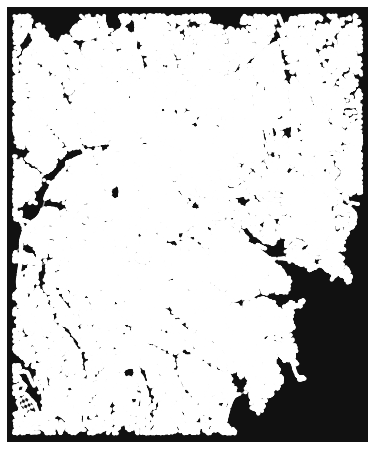

CPU times: user 58.5 s, sys: 570 ms, total: 59.1 s
Wall time: 58.8 s


In [5]:
%%time
fig, ax = ox.plot_graph(G)

## Extract nodes and edges as GeoPandas GDFs

In [6]:
nodes, edges = ox.graph_to_gdfs(G)
nodes

,y,x,street_count,highway,geometry
osmid,,,,,
26998731,0.352710,32.663264,4,NaN,POINT (32.66326 0.35271)
560793592,0.352865,32.663369,2,NaN,POINT (32.66337 0.35287)
6218466802,0.352640,32.663213,2,NaN,POINT (32.66321 0.35264)
2238616339,0.352698,32.662954,3,NaN,POINT (32.66295 0.35270)
6218576659,0.352773,32.664631,3,NaN,POINT (32.66463 0.35277)
...,...,...,...,...,...
9327732306,0.335654,32.589217,2,NaN,POINT (32.58922 0.33565)
9327732310,0.335595,32.589218,2,NaN,POINT (32.58922 0.33560)
9327732307,0.335680,32.589256,2,NaN,POINT (32.58926 0.33568)


## Create IPyLeaflet map

### Create Map object

**Note**: If you update any code in the cells below, you have to run everything again beginning with the code cell below.

In [7]:
center = (0.32245219939201997, 32.59300521351633)
m = Map(center=center, basemap=basemaps.CartoDB.Positron, zoom=15)
m.layout.width = '90%'
m.layout.height = '700px'

### Create GeoData objects out of GDFs

In [8]:
geo_data_p = GeoData(geo_dataframe = parishes_gdf,
    style={'color': 'black', 'fillColor': 'orange', 'opacity':0.5, 'weight':2, 'dashArray':'2', 'fillOpacity':0.05},
    hover_style={'fillColor': 'blue' , 'fillOpacity': 0.1},
    name = 'Parishes')

In [9]:
geo_data_tf = GeoData(geo_dataframe = filtered_testing_sites_gdf,
    style={'color': 'black', 'radius':8, 'fillColor': '#3366cc', 'opacity':0.5, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
    hover_style={'fillColor': 'red' , 'fillOpacity': 0.2},
    point_style={'radius': 5, 'color': 'red', 'fillOpacity': 0.8, 'fillColor': 'blue', 'weight': 3},
    name = 'Testing Facility')

### Create draggable Markers

In [10]:
#style for the destination marker
to_marker_style = AwesomeIcon(
    name='circle',
    icon_color='white',
    marker_color='blue',
    spin=False
)
#style for the destination marker
from_marker_style = AwesomeIcon(
    name='circle',
    icon_color='white',
    marker_color='red',
    spin=False
)
from_marker = Marker(location=center, icon=from_marker_style, name='Residence Marker (Red)')
to_marker = Marker(location=center, icon=to_marker_style, name='Testing Facility Marker (Blue)')

In [11]:
from_marker.location[0], from_marker.location[1]

(0.32245219939201997, 32.59300521351633)

### Define functions to be used for location change handling

In [12]:
def set_nearest_node(marker):
    marker.nearest_node = ox.distance.nearest_nodes(G, marker.location[1], marker.location[0])
    return

In [13]:
path_layer_list = []
def handle_change_location(event, marker):
    event_owner = event['owner']
    event_owner.nearest_node = ox.distance.nearest_nodes(G, event_owner.location[1], event_owner.location[0],)
    marker.nearest_node = ox.distance.nearest_nodes(G, marker.location[1], marker.location[0])
    
    shortest_path = nx.dijkstra_path(G, event_owner.nearest_node, marker.nearest_node, 
                                     weight='length')
    
    if len(path_layer_list) == 1:
        m.remove_layer(path_layer_list[0])
        path_layer_list.pop()
    
    shortest_path_points = nodes.loc[shortest_path]
    path = gpd.GeoDataFrame([LineString(shortest_path_points.geometry.values)], columns=['geometry'])
    path_layer = GeoData(geo_dataframe=path, style={'color':'red', 'weight':3}, name='Route')
    m.add_layer(path_layer)
    path_layer_list.append(path_layer)

### Attach location change function to markers

In [14]:
from_marker.observe(lambda event: handle_change_location(event, to_marker), 'location')
to_marker.observe(lambda event: handle_change_location(event, from_marker), 'location')

### Plot map!

In [15]:
m.add_layer(from_marker)
m.add_layer(to_marker)
m.add_layer(geo_data_tf)
m.add_layer(geo_data_p)
m.add_control(FullScreenControl())
m.add_control(LayersControl())
set_nearest_node(from_marker)
set_nearest_node(to_marker)
m

Map(center=[0.32245219939201997, 32.59300521351633], controls=(ZoomControl(options=['position', 'zoom_in_text'…